In [28]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
from bvhpython.bvh import Bvh
from scipy.interpolate import interp1d
import os
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.losses import SparseCategoricalCrossentropy, mse, CategoricalCrossentropy
from keras.activations import relu
from keras.layers.normalization import BatchNormalization
import datetime
from sklearn.metrics import confusion_matrix
import sklearn

%run Gestion_temps.ipynb


%run Gestion_temps.ipynb
%run modelisation.ipynb
%run bvh_extract.ipynb
%run algo_genetique.ipynb
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
path_bvh_data = 'data/bvh'
path_csv_data = 'data/csv'
path_csv_norm_data = 'data/csv_norm'
path_csv_norm_interp_data = 'data/csv_norm_interp'

# hanche : 1-6
hanche = np.array(range(0,6)) # h

# cuisse droite : 7-12
# mollet droit : 13-18
# pied droit : 19-24
cuisse_droite = np.array(range(6,12)) # cd
mollet_droit = np.array(range(12,18)) # md
pied_droit = np.array(range(18,24)) # pd
jambe_droite = np.array([cuisse_droite,
               mollet_droit,
               pied_droit])

# cuisse gauche : 25-30
# mollet gauche : 31-36
# pied gauche : 37-42
cuisse_gauche = np.array(range(24,30)) # cg
mollet_gauche = np.array(range(30,36)) # mg
pied_gauche = np.array(range(36,42)) # pg
jambe_gauche = np.array([cuisse_gauche,
               mollet_gauche,
               pied_gauche])

# vertebre 43-48
# vertebre 1 : 49-54
# vertebre 2 : 55-60
# vertebre 3 : 61-66
vertebre = np.array(range(42,48)) # v
vertebre_1 = np.array(range(48,54)) # V1
vertebre_2 = np.array(range(54,60)) # v2
vertebre_3 = np.array(range(60,66)) # v3

# nuque : 67-72
# tete : 73-78
nuque = np.array(range(66,72)) # n
tete = np.array(range(72,78)) # t

tronc = np.array([tete,
        nuque,
        vertebre_3,
        vertebre_2,
        vertebre_1,
        vertebre])

# epaule droite : 79-84
# bras droit : 85-90
# avant-bras : 91-96
# main droite : 97-102
epaule_droite = np.array(range(78,84)) # ed
biceps_droit = np.array(range(84,90)) # bd
avant_bras_droit = np.array(range(90,96)) # abd
main_droite = np.array(range(96,102)) # md
bras_droit = np.array([epaule_droite,
             biceps_droit,
             avant_bras_droit,
             main_droite])

# epaule gauche : 217-222
# bras gauche : 223-228
# avant-bras gauche : 229-234
# main gauche : 235-240
epaule_gauche = np.array(range(216,222)) # eg
biceps_gauche = np.array(range(222,228)) # bg
avant_bras_gauche = np.array(range(228,234)) # abg
main_gauche = np.array(range(234,240)) # mg
bras_gauche = np.array([epaule_gauche,
              biceps_gauche,
              avant_bras_gauche,
              main_gauche])

corp = np.array([tronc,
       bras_droit,
       bras_gauche,
       jambe_droite,
       jambe_gauche])

corp_flat = np.array([])
for i in corp:
    for j in i:
        corp_flat = np.append(corp_flat, j)
        
corp_flat = np.sort(corp_flat)

In [3]:
np.where(corp_flat==96)[0][0]

90

In [4]:
list_csv = os.listdir(path_csv_data)
print(list_csv)

['marche_3Char00.bvh.csv', 'marche_jb_3Char00.bvh.csv', 'marche_4Char00.bvh.csv', 'marche_p_3Char00.bvh.csv', 'marche_pChar00.bvh.csv', 'marche_chuChar00.bvh.csv', 'marche_p_4Char00.bvh.csv', 'marche_jbChar00.bvh.csv', 'marcheChar00.bvh.csv', 'marche_p_5Char00.bvh.csv', 'marche_p_2Char00.bvh.csv', 'marche_p_6Char00.bvh.csv', 'marche_p_7_bdChar00.bvh.csv', 'marche_5Char00.bvh.csv', 'marche_1Char00.bvh.csv', 'marche_jb_2Char00.bvh.csv', 'marche_2Char00.bvh.csv']


Text(0.5, 0, 'frame')

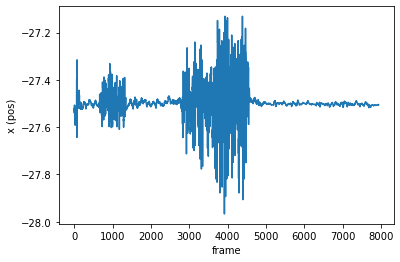

In [22]:
f = 'marche_p_5Char00.bvh.csv'
m_p5_md = pd.read_csv(path_csv_data + '/' + f)['96']

f = 'marcheChar00.bvh.csv'
m_md = pd.read_csv(path_csv_data + '/' + f)['96']

m_p5_md.plot()
#m_md.plot()
plt.ylabel('x (pos)')
plt.xlabel('frame')


0.4679929999999999 0.8364119999999993


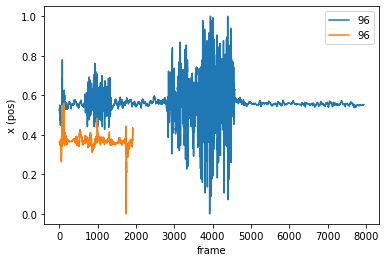

In [27]:
f = 'marche_p_5Char00.bvh.csv'
m_p5_md = pd.read_csv(path_csv_data + '/' + f)['96']

f = 'marcheChar00.bvh.csv'
m_md = pd.read_csv(path_csv_data + '/' + f)['96']

m_p5_md = m_p5_md + abs(min(m_p5_md))
m_md = m_md + abs(min(m_md))

print(max(m_md), max(m_p5_md))

m_p5_md_norm = m_p5_md / max(m_p5_md)
m_md_norm = m_md / max(m_p5_md)

m_p5_md_norm.plot()
m_md_norm.plot()
plt.ylabel('x (pos)')
plt.xlabel('frame')
plt.legend()

In [47]:

for f in list_csv:
    df = pd.read_csv(path_csv_data + '/' + f,index_col=0, dtype='float')
    # trie de données
    # on récupère que les données utiles du corp
    df = pd.DataFrame(np.array([df[str(int(x))] for x in corp_flat]).T)
    # normalisation des données entre 0 et 1
    
    for v in corp_flat:
        v = np.where(corp_flat==v)[0][0]
        #df[v] = df[v] + abs(min(df[v]))
        df[v] = sklearn.preprocessing.scale(df[v])
        df[v] = df[v] / max(abs(df[v]))
        
    
    df.to_csv(path_csv_norm_data + '/' + f)
    

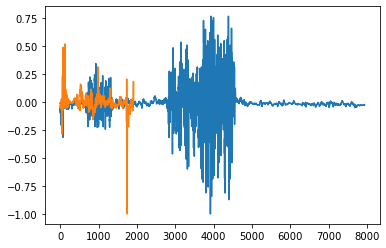

In [48]:
f = 'marche_p_5Char00.bvh.csv'
df = pd.read_csv(path_csv_norm_data + '/' + f, index_col=0)
df['90'].plot()

f = 'marcheChar00.bvh.csv'
m_md = pd.read_csv(path_csv_norm_data + '/' + f, index_col=0)
m_md['90'].plot()

In [72]:

for f in list_csv:
    #df = pd.read_csv(path_csv_norm_data + '/' + f).to_numpy()[1:]
    df = pd.read_csv(path_csv_norm_data + '/' + f,index_col=0)
    function = interp1d(np.array(range(df.shape[0])),df,axis=0,
                       kind='cubic')
    m = pd.DataFrame(function(np.linspace(0,df.shape[0]-1,16000)))
    m.to_csv(path_csv_norm_interp_data + '/' + f)
    


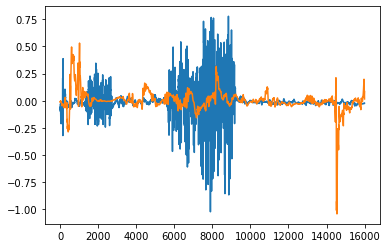

In [660]:
f = 'marche_p_5Char00.bvh.csv'
df = pd.read_csv(path_csv_norm_interp_data + '/' + f, index_col=0)
df['90'].plot()

f = 'marcheChar00.bvh.csv'
df1 = pd.read_csv(path_csv_norm_interp_data + '/' + f, index_col=0)
df1['90'].plot()

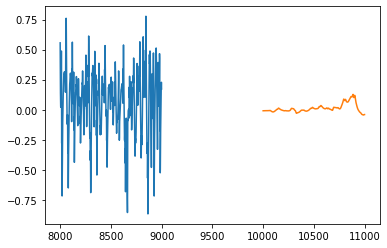

In [663]:
df['90'][8000:9000].plot()
df1['90'][10000:11000].plot()

In [664]:
x_train = np.array([[df['90'][10000:11000]],
                    [df1['90'][10000:11000]],
                    [df1['90'][1500:2500]],
                    [df1['90'][8000:9000]]])
x_test = x_train
print(x_train.shape)
y_train = np.array([[1,0],[1,0],[0,1],[0,1]])
#y_train = np.vstack([y_train,y_train_2])
y_test = y_train
print(y_train.shape)
y_train

(4, 1, 1000)
(4, 2)


array([[1, 0],
       [1, 0],
       [0, 1],
       [0, 1]])

In [684]:
model = Sequential()

model.add(LSTM(10, 
                activation="tanh",
                return_sequences=True,
                input_shape=(1,1000),
                recurrent_dropout=0.8))
model.add(LSTM(10,
                recurrent_dropout=0.8))
model.add(Dense(2,
                activation='softmax'))
model.compile( loss = "mse", 
                optimizer = optimizers.Adam(lr = 0.01),
                metrics = ['accuracy'])
model.summary()

Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_331 (LSTM)              (None, 1, 10)             40440     
_________________________________________________________________
lstm_332 (LSTM)              (None, 10)                840       
_________________________________________________________________
dense_155 (Dense)            (None, 2)                 22        
Total params: 41,302
Trainable params: 41,302
Non-trainable params: 0
_________________________________________________________________


[0.0, 0.75, 1.0, 0.75]
[0.25044894218444824, 0.23919177055358887, 0.2267555296421051, 0.21349281072616577]


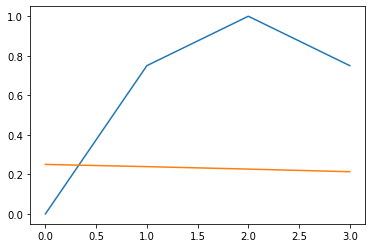

In [685]:
history = model.fit(x_train,y_train,epochs=4,verbose=0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
print(history.history['accuracy'])
print(history.history['loss'])

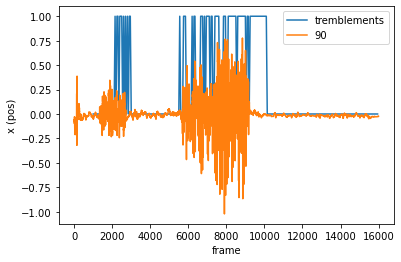

In [686]:
res = np.array([])

for i in range(0,15000,50):
    test = np.array([[df['90'][i:i+1000]]])
    prediction = model.predict(test)
    res = np.append(res,prediction.argmax())
    
ordo = np.array(range(0,15000,50)) + 1000
plt.plot(ordo,res,label='tremblements')
f = 'marche_p_5Char00.bvh.csv'
df = pd.read_csv(path_csv_norm_interp_data+'/'+f,index_col=0)
df['90'].plot()
plt.ylabel('x (pos)')
plt.xlabel('frame')
plt.legend()
#res

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_267 (LSTM)              (None, 1, 30)             123720    
_________________________________________________________________
lstm_268 (LSTM)              (None, 30)                7320      
_________________________________________________________________
dense_123 (Dense)            (None, 2)                 62        
Total params: 131,102
Trainable params: 131,102
Non-trainable params: 0
_________________________________________________________________
None
test loss, test acc: [0.24894097447395325, 1.0]
[[10]]
INFO:tensorflow:Assets written to: model/model_2/assets


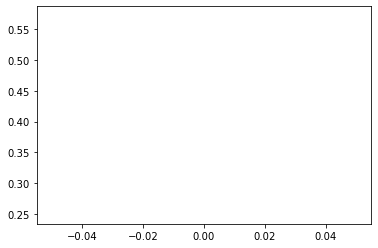

In [562]:
    ## %run modelisation.ipynb
# %tensorboard --logdir logs/fit

md = motion_detection()
md.start('data', x_train, 
         y_train, 
         x_test, 
         y_test, 
         (30,30), 
         0.0001,
         1, 
         1,
         0.5,
         "tanh", 
         1, 
         0)


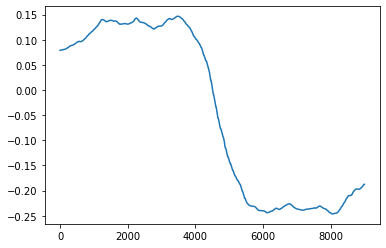

In [73]:
plt.plot(x_train[0,3])

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 354, 43)           1555568   
_________________________________________________________________
batch_normalization_15 (Batc (None, 354, 43)           172       
_________________________________________________________________
lstm_50 (LSTM)               (None, 30)                8880      
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 62        
Total params: 1,564,682
Trainable params: 1,564,596
Non-trainable params: 86
_________________________________________________________________
None
Epoch 1/37
Epoch 2/37
Epoch 3/37
Epoch 4/37
Epoch 5/37
Epoch 6/37
Epoch 7/37
Epoch 8/37
Epoch 9/37
Epoch 10/37
Epoch 11/37
Epoch 12/37
Epoch 13/37
Epoch 14/37
Epoch 15/37
Epoch 16/37
Epoch 17/37
Epoch 18/37
Epoch 19/37
Epoch 20/37
Epoc

KeyboardInterrupt: 

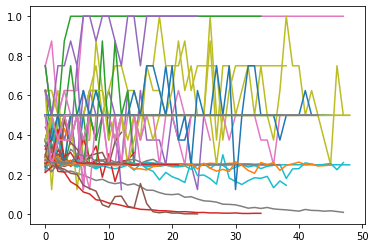

In [50]:
%run algo_genetique.ipynb

t = test('data', x_train, y_train, x_test, y_test)
t.start(10)

[-222.73712158 -222.75411987 -221.25302124 -220.48362732 -221.1158905
 -219.50312805 -219.40139771 -219.58151245 -218.80999756 -218.69155884
 -218.85389709 -219.81625366 -219.39605713 -222.20172119 -221.76835632
 -222.31994629 -222.35884094 -226.20680237 -224.71310425 -223.27893066
 -224.80448914 -225.16653442 -222.4690094  -222.87828064 -221.99227905
 -222.24784851 -223.00605774]
(48, 27)
[[-222.73712158 -222.75062022 -221.87112068 ... -222.56005231
  -223.16215964 -223.76426697]
 [ 540.99542236  541.14087812  541.87449736 ...  547.03614358
   549.80707326  552.57800293]
 [2832.40991211 2830.58223949 2828.99310662 ... 2820.44297162
  2819.51701804 2818.59106445]
 ...
 [ -18.1917305   -16.74520672  -16.7386156  ...  -15.58041516
   -19.64235325  -23.70429134]
 [-930.29620361 -934.23218491 -935.40111946 ... -938.12389778
  -926.61685001 -915.10980225]
 [2827.43798828 2826.27337287 2827.4635656  ... 2858.37966739
  2863.41773897 2868.45581055]]


(45, 35)

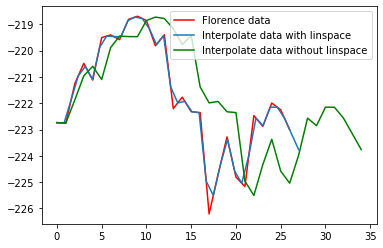

In [81]:
# Creation of the mvt data base of the Florence university

# Initialization of the mvt tab
# allow to use np.vstack() function of numpy lib
# vstack stack object of the same size

# mvts is a array of 3-column
# 1 => actor id
# 2 => category id
# 3 => mvt belonging to the two previous id's
mvts = np.array([0, 0, [[ x for x in range(nb_frame_max)] for y in range(45)]])

# browse of all id video
for n in unique:
    
    idvideo = int(n)
    
    # motion recovery
    tmp = mvt[mvt[:,0] == idvideo]
    
    # index 0 = idvideo
    # index 1 = idactor
    # index 2 = idcategory
    idcat = int(tmp[0,2])
    idactor = int(tmp[0,1])
    
    # id data removing
    tmp = tmp[:,3:]
    
    # preparing the normalized matrice
    m_n = np.zeros((nb_frame_max, 45))
    
    # nb frame of the motion
    dim_m = tmp.shape[0]
    
    i = 0
    # interpolation
    while i < tmp.shape[1]:
        f = interp1d(np.arange(dim_m), tmp[:,i], fill_value='extrapolate')
        m_n[:,i] = np.array(f(np.linspace(0, dim_m, nb_frame_max)))
        i += 1
    
    tmp = m_n
    # the mvt is transposed in order to have time-based coordinates 
    tmp = np.array([idactor, idcat, tmp.T])
    
    mvts = np.vstack([mvts, tmp])

# removing the first iteration of the mvt tab 
# which was created for vstack function
mvts = mvts[1:]

# comparision before / after
tmp = mvt[mvt[:,0] == 1].T
print(tmp[3])
print(tmp.shape)

# plot
plt.plot(tmp[3],'r-', label="Florence data")
plt.plot(np.linspace(0,27,nb_frame_max), mvts[0,2][0,:], label="Interpolate data with linspace")
plt.plot(mvts[0,2][0,:], 'g-', label="Interpolate data without linspace")
plt.legend()

print(mvts[0,2])
mvts[0,2].shape

In [82]:
# Creation of the train and test dataset

# train data contains all data except the data of actor one
tmp = mvts[mvts[:,0] != 1]
x_train = np.array([x[2] for x in tmp])
y_train = tmp[:,1]

# test data contains data of actor 1 only
tmp = mvts[mvts[:,0] == 1]
x_test =  np.array([x[2] for x in tmp])
y_test = np.array(tmp[:,1], dtype="int")


## 